In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),  
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='Localhost',
    user='*****',
    password='*******',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = '/Users/anikbanik/Desktop/New Data for project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "Localhost",
                             username = "root",
                             password = "Banglauk8!",
                             database = "ecommerce")

cur = db.cursor()
                             

                             

# List all unique cities where customers are located

In [4]:
query = """ Select DiStinct customer_city From customers """

cur.execute(query)

data = cur.fetchall()

data
df = pd.DataFrame(data)
df.head()



,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017 

In [5]:
query = """  Select count(order_id) From orders 
where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"Total order placed in 2017 are ", data[0][0]

('Total order placed in 2017 are ', 721616)

# Find the total sales per category.

In [6]:
query = """  Select Upper(products.product_category) category, round(sum(payments.payment_value),2) sales
from products
join order_items
on products.product_id = order_items. product_id
join payments
on payments.order_id = order_items.order_id
group by category  """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns =["category", "sales"])
df.head()
df

,category,sales
0,PERFUMERY,1.370221e+09
1,FURNITURE DECORATION,3.867197e+09
2,TELEPHONY,1.316529e+09
3,BED TABLE BATH,4.630745e+09
4,AUTOMOTIVE,2.304604e+09
...,...,...
69,CDS MUSIC DVDS,3.243259e+06
70,LA CUISINE,7.878185e+06
71,FASHION CHILDREN'S CLOTHING,2.124452e+06
72,PC GAMER,5.879659e+06


# Calculate the percentage of orders that were paid in installments

In [7]:
query = """  Select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100
from payments """

cur.execute(query)

data = cur.fetchall()
"the percentage of orders that were paid in installments", data

('the percentage of orders that were paid in installments',
 [(Decimal('99.9981'),)])

# Count the number of customers from each state.

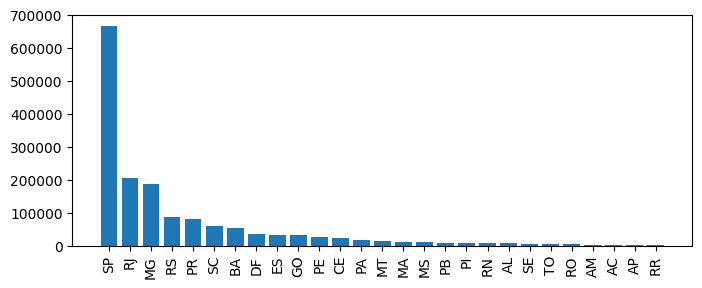

In [8]:
query = """  select distinct customer_state, count(customer_id) customer_no from customers
group by customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending= False)
plt.figure(figsize =(8,3))
plt.bar(df["state"], df["customer_count"])

plt.xticks(rotation = 90)
plt.show()


# Calculate the number of orders per month in 2018

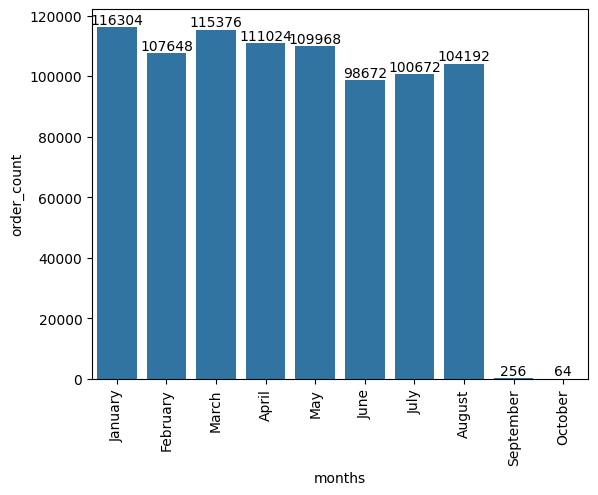

In [9]:
query = """  Select monthname(order_purchase_timestamp) months, count(order_id) order_count
From orders where year(order_purchase_timestamp) = 2018
group by months """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March","April","May","June","July","August", "September","October"]
ax = sns.barplot(x = df["months"], y = df["order_count"], data =df, order = o) 
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city.

In [10]:
query = """with count_per_order as(
Select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
From orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id
)
Select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
From customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
 """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns =["customer_city", "average_orders"])
print(df.head(10))

        customer_city average_orders
0      padre carvalho        1456.00
1         celso ramos        1352.00
2               datas        1248.00
3       candido godoi        1248.00
4      matias olimpio        1040.00
5          cidelandia         832.00
6          curralinho         832.00
7             picarra         832.00
8  morro de sao paulo         832.00
9     teixeira soares         832.00


# Calculate the percentage of total revenue contributed by each product category.

In [11]:
query = """  Select upper(products.product_category) category, round((sum(payments.payment_value)/(Select sum(payment_value) from payments))*100,2) 
percentage_distribution
from products
join order_items
on products.product_id = order_items. product_id
join payments
on payments.order_id = order_items.order_id
group by category order by percentage_distribution
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns =["category", "sales"])
df.head()


,category,sales
0,INSURANCE AND SERVICES,0.42
1,FASHION CHILDREN'S CLOTHING,1.02
2,CDS MUSIC DVDS,1.56
3,HOUSE COMFORT 2,2.22
4,PC GAMER,2.83


# Identify the correlation between product price and the number of times a product has been purchased 

In [12]:
query = """ Select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
From products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns =["Category", "order_count", "price"])
df.head()

arr1 = df["order_count"]
arr2 = df["price"]
a= np.corrcoef([arr1, arr2])
print("The coorelation between product price and the number of times a product has been purchased is", a[0][1])

The coorelation between product price and the number of times a product has been purchased is -0.10631514167157566


# Calculate the total revenue generated by each seller, and rank them by revenue. 

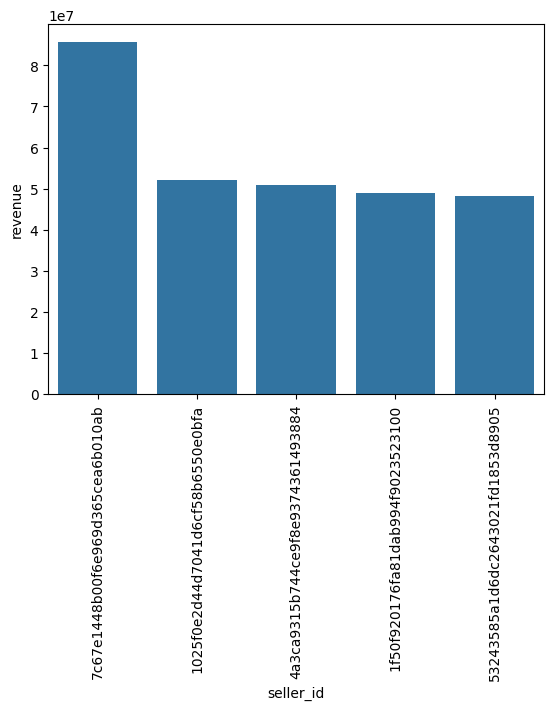

In [21]:
query = """ Select *, dense_rank() over(order by revenue desc) as rn
from
(select order_items.seller_id, round(sum(payments.payment_value),2) revenue
From order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)

data = cur.fetchall()
data
df= pd.DataFrame(data, columns = ["seller_id", "revenue", "rn"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.  

In [25]:
query = """Select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg
from
(Select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)

data = cur.fetchall()
df= pd.DataFrame(data)
df.head()


,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998


# Calculate the cumulative sales per month for each year. 

In [29]:
query = """Select years, months, payment, round(sum(payment) 
over(order by years, months),2) cumulative_sales from
(Select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from orders join payments 
on orders.order_id = payments.order_id
group by years, months order by years, months) as a"""

cur.execute(query)

data = cur.fetchall()
df= pd.DataFrame(data, columns = ["years", "months", "payment", "cumulative_sales"])
df.head()


,years,months,payment,cumulative_sales
0,2016,9,52465.92,5.246592e+04
1,2016,10,12290819.84,1.234329e+07
2,2016,12,4080.96,1.234737e+07
3,2017,1,28805512.33,4.115288e+07
4,2017,2,60716865.98,1.018697e+08


# Calculate the year-over-year growth rate of total sales 

In [42]:
query = """with cte as (Select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from orders join payments 
on orders.order_id = payments.order_id
group by years order by years)

select years, 
((payment-lag(payment,1) over(order by years))/ lag(payment,1) over(order by years)) * 100 previous_year from cte
"""

cur.execute(query)

data = cur.fetchall()
cur.execute(query)

df = pd.DataFrame(data, columns = ["years", "Year_Growth %"])
df.head()

,years,Year_Growth %
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year.

In [56]:
query = """ select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <=3
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "payment", "drank"])
df.head(12 )



,years,id,payment,drank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,2.960984e+05,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,2.913539e+05,2
2,2016,4a06381959b6670756de02e07b83815f,2.553782e+05,3
3,2017,1617b1357756262bfa56ab541c47bc16,2.842129e+06,1
4,2017,c6e2731c5b391845f6800c97401a43a9,1.441296e+06,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,1.399145e+06,3
6,2018,ec5b2ba62e574342386871631fafd3fc,1.513175e+06,1
7,2018,f48d464a0baaea338cb25f816991ab1f,1.439820e+06,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,1.000364e+06,3
